In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
from PIL import Image
import torch
import matplotlib.pyplot as plt

/home/stefano/projects/single-view-3d/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load an example image
image_path = os.path.join(project_root, 'assets', 'colmap', 'images', 'IMG_8223.jpg')
image = Image.open(image_path)

# Load processor and model
processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to("cuda" if torch.cuda.is_available() else "cpu")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]


In [4]:
# Prepare input
inputs = processor(images=image, return_tensors="pt").to(model.device)

In [5]:
# Inference
with torch.no_grad():
    outputs = model(**inputs)

In [6]:
# Post-process to get depth map and camera parameters
post = processor.post_process_depth_estimation(outputs, target_sizes=[(image.height, image.width)])

In [7]:
depth_map = post[0]["predicted_depth"]
focal_length_px = post[0]["focal_length"]
field_of_view = post[0]["field_of_view"]  # optional

print(f"Depth map shape: {depth_map.shape}")
print(f"Estimated focal length (px): {focal_length_px}")
print(f"Estimated field of view (degrees): {field_of_view}")

Depth map shape: torch.Size([4284, 5712])
Estimated focal length (px): 5208.80517578125
Estimated field of view (degrees): 57.47212219238281


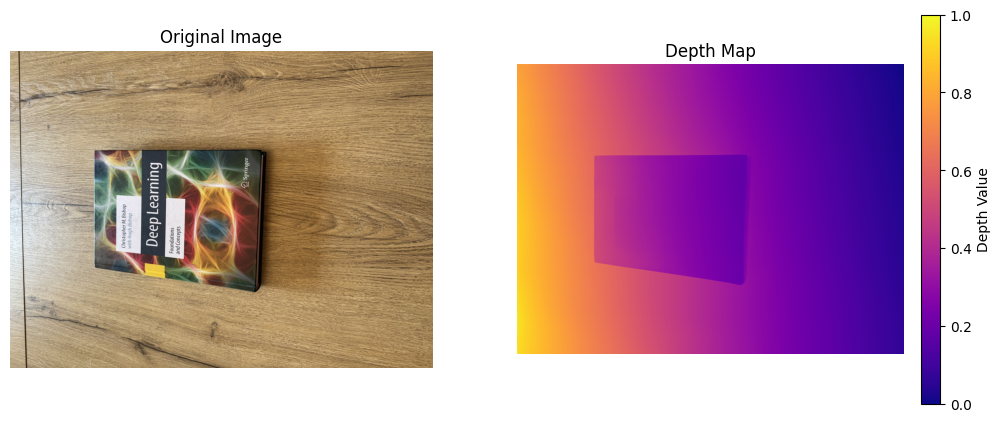

In [8]:
# Display the image and the depth map
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map.squeeze().cpu().detach().numpy(), cmap="plasma")
plt.title("Depth Map")
plt.axis("off")

# Add a colorbar for depth map
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=plt.gca(), fraction=0.046, pad=0.04)
cbar.set_label('Depth Value')

plt.show()